In [1]:
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys,os

from statannot import add_stat_annotation
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from glob import glob

def load_fasta(fil):
    seqs, IDs =[], []
    with open(fil) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                seq = ''.join([x for x in record.seq if not x.islower()])
                IDs.append(record.id)
                seqs.append(seq)
    return IDs, seqs

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
d = pd.read_json('RelaxDB_with_other_metrics_22jan2025.json.zip')
for col in d.columns:
    if isinstance(d[col].iloc[0],list):
        d[col] = [np.asarray(x,dtype=float) for x in d[col]]

print(len(d))

133


In [8]:
m=[]

for _, row in d.iterrows():
    for i in range(len(row['sequence'])):
        start = row['missing_peaks'].find('A')
        end = row['missing_peaks'].rfind('A')
        if i >= start and i <= end: # and i >= int(0.05*row['seq length']) and i <= int(0.95*row['seq length']):
            if row['sequence'][i]=='P':
                label='Pro'
            elif row['missing_peaks'][i]=='.':
                label='missing'
            elif row['label'][i] == 'x':
                label='na'
            elif row['label'][i] == 'v':
                label='low'
            elif row['label'][i]=='^':
                label='high'
            elif row['label'][i] == 'b':
                label='high'
            else:
                label='mid'
        else:
            label='term'

        dssp_dct={'C': 'Loop','E':'Sheet','H':'Helix', ' ': 'Loop'}

        m.append({'AA': row['sequence'][i],
                  'seqpos': i,
                  'entry_ID': row['entry_ID'],
                  'Classification': row['Classification'],
                  'DSSP': dssp_dct[row['DSSP'][i]],
                  'R2_R1': row['R2_R1'][i],
                  'dR2': row['dR2'][i],
                  'cons': row['cons_BLOSUM62'][i],
                  'coverage': row['coverage'][i],
                    'pLDDT': row['pLDDT'][i],
                  'SASA': row['SASA'][i],
                  'NOE': row['NOE'][i],
                  'label':label})

melt = pd.DataFrame.from_records(m)

In [9]:
len(melt.loc[melt.label.isin(['low','mid','high','missing'])])

13724

/var/folders/dz/yxswm4nd5gn8qr7s1_h0x71r0000gn/T/ipykernel_39979/3746051915.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = melt.loc[melt.label.isin(['low','mid','high'])][melt.entry_ID!='MK12']


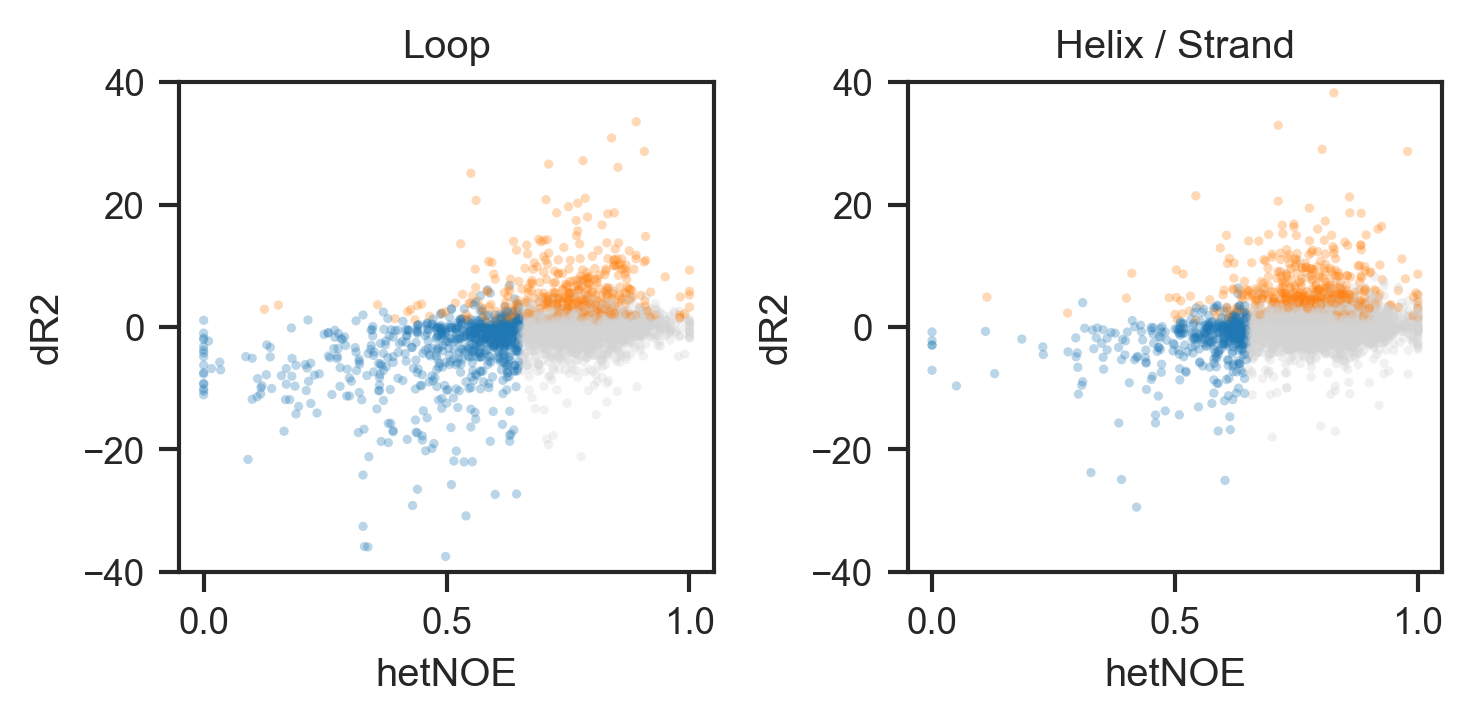

In [10]:
plt.figure(figsize=(5,2.5))
subplot(1,2,1)

subset = melt.loc[melt.label.isin(['low','mid','high'])][melt.entry_ID!='MK12']
title('Loop')
sns.scatterplot(x='NOE',y='dR2', hue='label',
    data=subset[subset.DSSP=='Loop'],palette=['tab:blue','lightgrey','tab:orange'],
               alpha=0.3,linewidth=0, s=5)
#axhline(3,color='k',zorder=0,linewidth=0.25)
xlabel('hetNOE')
ylabel('dR2')
ylim([-40,40])
legend([],frameon=False)

subplot(1,2,2)

title('Helix / Strand')
sns.scatterplot(x='NOE',y='dR2', hue='label',
    data=subset[subset.DSSP!='Loop'],palette=['lightgrey','tab:orange','tab:blue'],
               alpha=0.3,linewidth=0, s=5)
#axhline(3,color='k',zorder=0,linewidth=0.25)

xlabel('hetNOE')
ylim([-40,40])

legend([],frameon=False)

tight_layout()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.0_high v.s. 1.0_missing: t-test independent samples, P_val=4.639e-01 stat=-7.329e-01
0.0_high v.s. 0.0_missing: t-test independent samples, P_val=5.707e-02 stat=-1.906e+00
0.0_mid v.s. 0.0_high: t-test independent samples, P_val=4.160e-03 stat=-2.867e+00
0.0_low v.s. 0.0_mid: t-test independent samples, P_val=4.549e-10 stat=-6.246e+00
1.0_mid v.s. 1.0_high: t-test independent samples, P_val=5.586e-01 stat=-5.849e-01
1.0_low v.s. 1.0_mid: t-test independent samples, P_val=1.484e-28 stat=-1.115e+01


Text(0.5, 13.74999999999999, '')

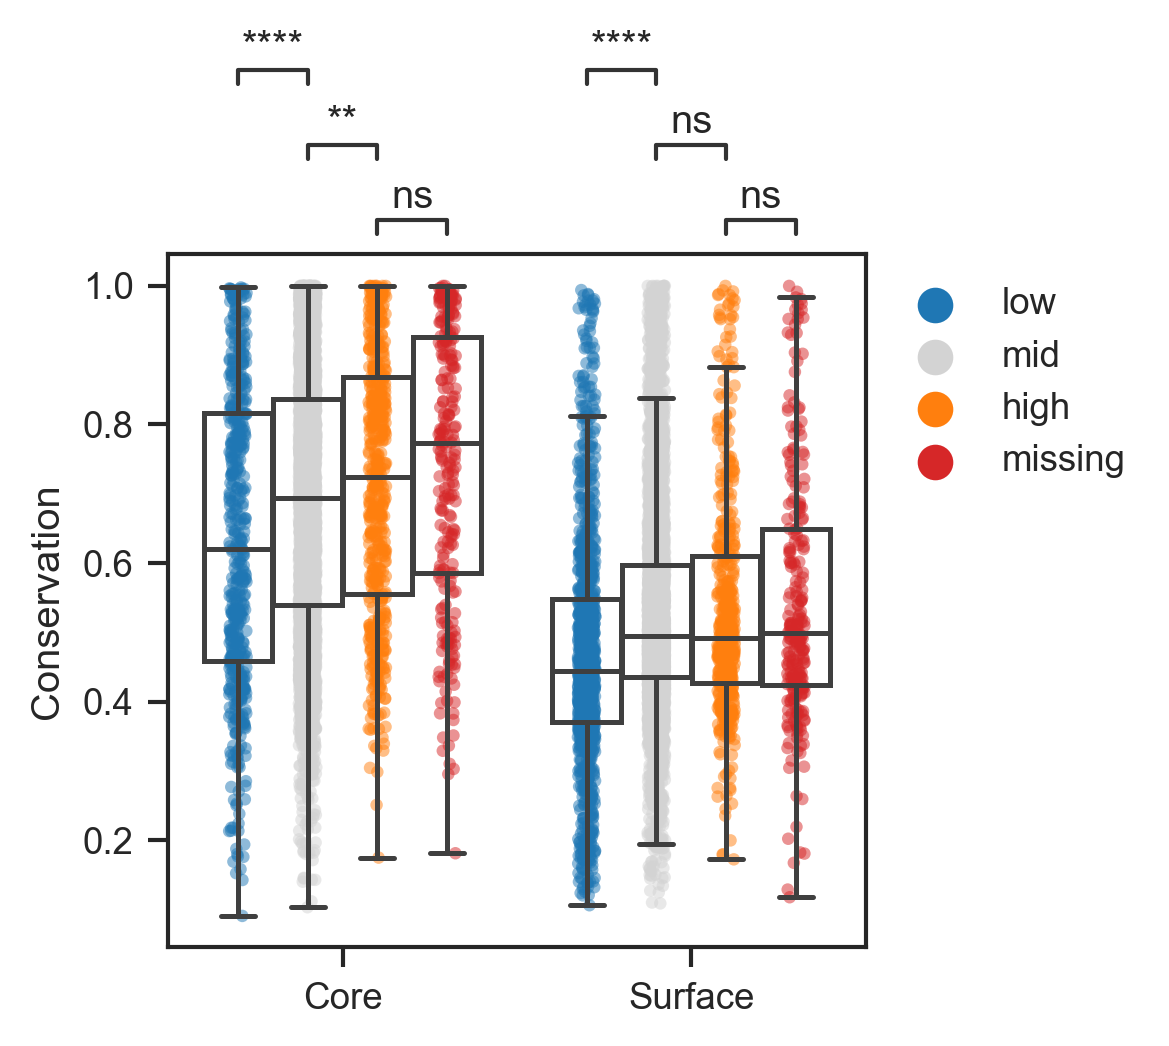

In [11]:

subset = melt.loc[~melt.label.isin(['Pro','term'])]
order=['low','mid','high','missing']

def jitterbox(**kwargs):
    'supply x, y, hue, data'
    sns.stripplot(**kwargs, dodge=True, alpha=0.5,zorder=0,s=3)
    ax = sns.boxplot(**kwargs, dodge=True, fliersize=0, zorder=10, boxprops = dict(facecolor=(0,0,0,0)))

    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1, 1), frameon=False)
    return ax

figure(figsize=(3,3))
ax = jitterbox(hue='label',y='cons',data=subset,x='SASA',hue_order=order,palette=['tab:blue','lightgrey','tab:orange','tab:red'])

add_stat_annotation(hue='label',y='cons',data=subset,x='SASA',hue_order=order,linewidth=1,
                    test='t-test_ind',loc='outside', comparisons_correction=None,
                    ax=ax, box_pairs=[
                        ((1,'high'), (1,'missing')),
                        ((1,'mid'),  (1,'high')),
                        ((1,'mid'),  (1,'low')),
                        ((0,'mid'),  (0,'high')),
                        ((0,'mid'),  (0,'low')),
                        ((0,'high'), (0,'missing')),                                     
                                     ]
                    ,)

ylabel('Conservation')
xticks([0,1],['Core','Surface'])
xlabel('')

Text(0.5, 0, '')

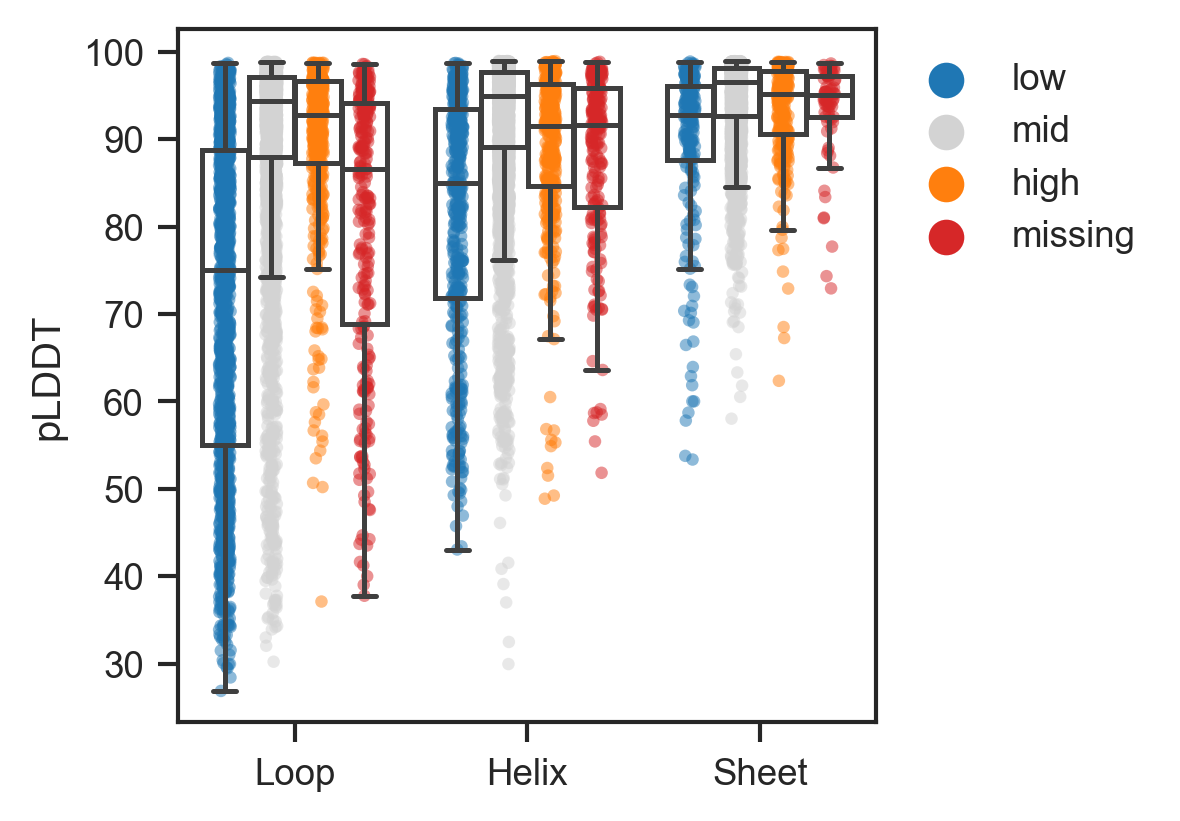

In [12]:
# compare to AF2 pLDDT
subset = melt.loc[~melt.label.isin(['Pro','term'])]
order=['low','mid','high','missing']

figure(figsize=(3,3))
ax = jitterbox(hue='label',y='pLDDT',data=subset,x='DSSP',hue_order=order,palette=['tab:blue','lightgrey','tab:orange','tab:red']) #,fliersize=0)


ylabel('pLDDT')
xlabel('')
